# Constructing a High-Dimensional Neural Network Potential for Lithium Aluminum Alloys with RuNNer and pyiron

This Jupyter Notebook is written for the RuNNer tutorial at the workshop "Potentials" from 08-10 June, 2022 by **Marius Herbold, Alexander L. M. Knoll, and Moritz R. Schäfer** (marius.herbold@chemie.uni-goettingen.de, aknoll@chemie.uni-goettingen.de, moritzrichard.schaefer@uni-goettingen.de, Georg-August-Universität Göttingen, Institut für Physikalische Chemie, Theoretische Chemie).

For this tutorial it is intended to use the RuNNer release version 1.2.
RuNNer is hosted on [Gitlab](https://gitlab.com/TheochemGoettingen/RuNNer).
The most recent version can only be found in this repository.
For access please contact Prof. Dr. Jörg Behler (joerg.behler@uni-goettingen.de).

In [6]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import ipympl
import ipywidgets as widgets

from pyiron_atomistics import Project
from pyiron_contrib.atomistics.runner.utils import container_to_ase, ase_to_container
from pyiron_contrib.atomistics.runner.job import RunnerFit

from runnerase import generate_symmetryfunctions

%matplotlib widget

# About RuNNer
**RuNNer** is a stand-alone Fortran program for the construction of high-dimensional neural network potentials (HDNNP), written mainly by Jörg Behler. It relates the local environment of an atom to its atomic energy $E_\mathrm{s}$, which contributes to the sum of all $N$ atomic energies, resulting in the total energy of the system $E_\mathrm{s}$

\begin{equation}
    E_\mathrm{s} = \sum_{a}^{N}E_\mathrm{a}.
\end{equation}

The atomic energy is described by an atomic neural network (NN), which is element specific. This gives the oppurtunity to describe different numbers of atoms with the same NN, which would be not the case, if there were only one NN for the whole system. To feed information to the NN, the local environment up to a certain cutoff radius $R_\mathrm{c}$ is described by so-called symmetry functions (SF) (more details are shown in a few moments) forming the SF vector $G$, which forms the input layer of the NN. In the next layers of the NN - the hidden layers - this information will be processed and in the final layer - the output layer - the atomic NN will provide the atomic energy $E_\mathrm{a}$. In each layer, there are a certain number of nodes $y$ which are connected by the weights $a$ and can be biased by the biases $b$. For the NN training the weights and biases are optimized to represent best the data in the training data set.

![2G-HDNNP](2G_HDNNP.png)

In general **RuNNer** can be separated into three different stages - so-called modes, in which different steps are performed.
- mode 1: SF calculation, data set splitting in training and test set
- mode 2: training of the NN to construct the NNP
- mode 3: prediction of energy, forces, stress, charges

All these steps are performed consecutively beginning with mode 1.

# pyiron and RuNNer

## Data Preparation

The creation of a meaningful neural network potential lives and dies with high quality training data. Therefore, we will begin by inspecting the full training dataset. 
The dataset has been stored prior to the workshop in form of a `TrainingContainer`. 
In pyiron, `TrainingContainer`s are jobs which take a set of structures and store them to HDF format.

Go ahead and open up the project:

In [7]:
pr = Project('AlLi-Fit')
# pr.unpack(csv_file_name='export.csv', origin_path='AlLi_export')

The project already contains several jobs:

In [8]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,140,finished,None,dataset_only_Li,/dataset_only_Li,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/AlLi-Fit/,2022-05-17 15:31:30.240841,NaT,NaN,pyiron@lap2p#1,TrainingContainer,0.4,NaN,None
1,141,finished,None,dataset_only_Al,/dataset_only_Al,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/AlLi-Fit/,2022-05-17 15:31:31.233602,NaT,NaN,pyiron@lap2p#1,TrainingContainer,0.4,NaN,None
2,142,finished,None,dataset_AlLi_stochiometric,/dataset_AlLi_stochiometric,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/AlLi-Fit/,2022-05-17 15:31:32.462426,NaT,NaN,pyiron@lap2p#1,TrainingContainer,0.4,NaN,None
3,143,finished,None,dataset_AlLi_offstochiometric,/dataset_AlLi_offstochiometric,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/AlLi-Fit/,2022-05-17 15:31:36.839004,NaT,NaN,pyiron@lap2p#1,TrainingContainer,0.4,NaN,None
4,144,finished,None,fit_dataset_full,/fit_dataset_full,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/AlLi-Fit/,2022-05-17 16:15:23.751902,NaT,NaN,pyiron@lap2p#1,RunnerFit,0.4,NaN,None
5,145,finished,None,dataset_full,/dataset_full,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/AlLi-Fit/,2022-05-18 12:31:07.194712,NaT,NaN,pyiron@lap2p#1,TrainingContainer,0.4,NaN,None
6,146,finished,None,fit_data_lithium_mode2,/fit_data_lithium_mode2,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/AlLi-Fit/,2022-05-25 09:41:18.489879,NaT,NaN,pyiron@lap2p#1,RunnerFit,0.4,148.0,None
7,148,finished,None,fit_data_lithium_mode1,/fit_data_lithium_mode1,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/AlLi-Fit/,2022-05-25 13:07:35.998221,NaT,NaN,pyiron@lap2p#1,RunnerFit,0.4,NaN,None
8,151,finished,None,fit_data_lithium_mode1,/fit_data_lithium_mode1,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/,2022-05-25 13:36:24.420734,2022-05-25 13:36:30.387102,5.0,pyiron@lap2p#1,RunnerFit,0.4,NaN,None
9,152,aborted,Li,job_a_3_4,/job_a_3_4,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/E_V_curve/,2022-05-25 13:39:02.177848,NaT,NaN,pyiron@lap2p#1,Lammps,0.1,NaN,None


The training data is stored in the project node `dataset_full`.

In [9]:
data_full = pr['AlLi-Fit/dataset_full']

In order to get a feel for the data, we inspect its energy-volume curve:

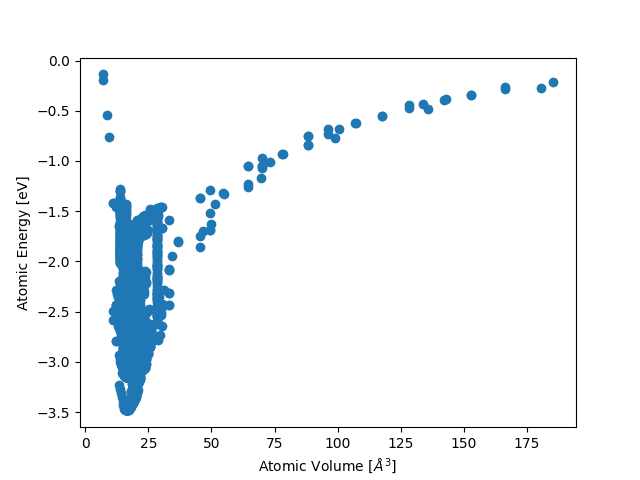

In [10]:
fig, ax = plt.subplots(1, 1)
_, plot = data_full.plot.energy_volume()
plt.show()

As you can see in this plot, some regions of configuration space are much more densily sampled than others. The dataset consists of approximately 4000 structures, ranging from bulk lithium and aluminum to off-stochiometric liquid phases of LiAl alloy. 

Training a potential for such a large dataset to high accuracy takes a few hours. Therefore, we are going to focus on a case study: the subset of pure lithium structures in the dataset. 

We extract a sample from the full dataset using `TrainingContainer`s convenient `sample` function. It creates a new `TrainingContainer` job (here we give it the name `data_lithium`) using a simple filter function.

In [11]:
def filter_lithium(container, idx):
    '''Returns True for structures without aluminum.'''
    elements = container.get_array('symbols', idx)
    return 'Al' not in elements

In [13]:
pr.remove_job('data_lithium')
data_lithium = data_full.sample('data_lithium', filter_lithium)

DataContainer({'save_neighbors': True, 'num_neighbors': 12})
The job data_lithium was saved and received the ID: 157


When inspecting the list of jobs in the project again, you will find that an additional `TrainingContainer`

In [14]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,140,finished,None,dataset_only_Li,/dataset_only_Li,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/AlLi-Fit/,2022-05-17 15:31:30.240841,NaT,NaN,pyiron@lap2p#1,TrainingContainer,0.4,NaN,None
1,141,finished,None,dataset_only_Al,/dataset_only_Al,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/AlLi-Fit/,2022-05-17 15:31:31.233602,NaT,NaN,pyiron@lap2p#1,TrainingContainer,0.4,NaN,None
2,142,finished,None,dataset_AlLi_stochiometric,/dataset_AlLi_stochiometric,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/AlLi-Fit/,2022-05-17 15:31:32.462426,NaT,NaN,pyiron@lap2p#1,TrainingContainer,0.4,NaN,None
3,143,finished,None,dataset_AlLi_offstochiometric,/dataset_AlLi_offstochiometric,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/AlLi-Fit/,2022-05-17 15:31:36.839004,NaT,NaN,pyiron@lap2p#1,TrainingContainer,0.4,NaN,None
4,144,finished,None,fit_dataset_full,/fit_dataset_full,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/AlLi-Fit/,2022-05-17 16:15:23.751902,NaT,NaN,pyiron@lap2p#1,RunnerFit,0.4,NaN,None
5,145,finished,None,dataset_full,/dataset_full,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/AlLi-Fit/,2022-05-18 12:31:07.194712,NaT,NaN,pyiron@lap2p#1,TrainingContainer,0.4,NaN,None
6,146,finished,None,fit_data_lithium_mode2,/fit_data_lithium_mode2,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/AlLi-Fit/,2022-05-25 09:41:18.489879,NaT,NaN,pyiron@lap2p#1,RunnerFit,0.4,148.0,None
7,148,finished,None,fit_data_lithium_mode1,/fit_data_lithium_mode1,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/AlLi-Fit/,2022-05-25 13:07:35.998221,NaT,NaN,pyiron@lap2p#1,RunnerFit,0.4,NaN,None
8,151,finished,None,fit_data_lithium_mode1,/fit_data_lithium_mode1,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/,2022-05-25 13:36:24.420734,2022-05-25 13:36:30.387102,5.0,pyiron@lap2p#1,RunnerFit,0.4,NaN,None
9,152,aborted,Li,job_a_3_4,/job_a_3_4,None,/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/E_V_curve/,2022-05-25 13:39:02.177848,NaT,NaN,pyiron@lap2p#1,Lammps,0.1,NaN,None


For comparison, here is the energy-volume curve from before:

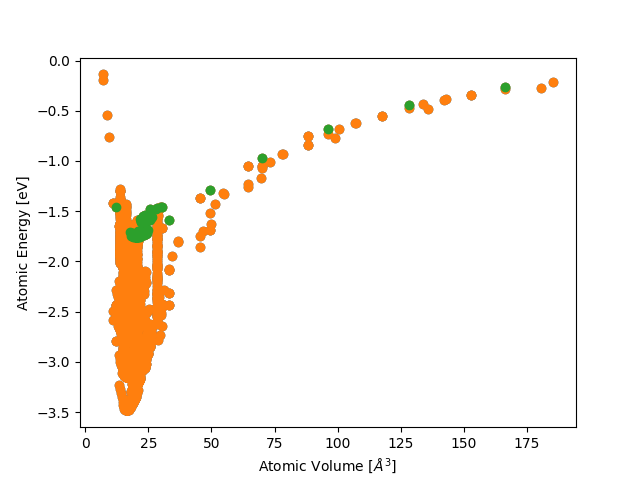

In [15]:
_, plot = data_full.plot.energy_volume()
_, plot = data_lithium.plot.energy_volume()

plt.show()

## Introduction of the `RunnerFit` job

pyiron and the RuNNer Fortran program communicate via a custom job type called `RunnerFit`. Here, we add a new job to the project via `create_job` and give it the name `fit_data_lithium`.

In [17]:
mode1 = pr.create_job(RunnerFit, 'fit_data_lithium_mode1')

Every `RunnerFit` job is initialized with a sensible choice of input parameters for RuNNer and an empty storage for training structures. This information can easily be accessed through the `input` property.  

In [18]:
mode1.input

DataContainer({'parameters': DataContainer({'runner_mode': 1, 'elements': None, 'number_of_elements': 0, 'bond_threshold': 0.5, 'nn_type_short': 1, 'use_short_nn': 1, 'optmode_charge': 1, 'optmode_short_energy': 1, 'optmode_short_force': 1, 'points_in_memory': 1000, 'scale_symmetry_functions': 1, 'cutoff_type': 1, 'test_fraction': 0.1, 'use_short_forces': 1, 'epochs': 30, 'kalman_lambda_short': 0.98, 'kalman_nue_short': 0.9987, 'mix_all_points': 1, 'nguyen_widrow_weights_short': 1, 'repeated_energy_update': 1, 'short_energy_error_threshold': 0.1, 'short_energy_fraction': 1.0, 'short_force_error_threshold': 1.0, 'short_force_fraction': 0.1, 'use_old_weights_charge': 0, 'use_old_weights_short': 0, 'write_weights_epoch': 5, 'center_symmetry_functions': 1, 'precondition_weights': 1, 'global_activation_short': [['t', 't', 'l']], 'global_hidden_layers_short': 2, 'global_nodes_short': [[15, 15]], 'symfunction_short': [('Li', 2, 'Li', 0.0, 0.0, 12.0), ('Li', 2, 'Li', 0.004675055980246072, 0.0, 12.0), ('Li', 2, 'Li', 0.010843416275634649, 0.0, 12.0), ('Li', 2, 'Li', 0.01939424193215976, 0.0, 12.0), ('Li', 2, 'Li', 0.03192971575337408, 0.0, 12.0), ('Li', 2, 'Li', 0.05159916711157465, 0.0, 12.0), ('Li', 3, 'Li', 'Li', 0.0, -1.0, 1.0, 12.0), ('Li', 3, 'Li', 'Li', 0.0, -1.0, 2.0, 12.0), ('Li', 3, 'Li', 'Li', 0.0, -1.0, 4.0, 12.0), ('Li', 3, 'Li', 'Li', 0.0, -1.0, 8.0, 12.0), ('Li', 3, 'Li', 'Li', 0.0, 1.0, 1.0, 12.0), ('Li', 3, 'Li', 'Li', 0.0, 1.0, 2.0, 12.0), ('Li', 3, 'Li', 'Li', 0.0, 1.0, 4.0, 12.0), ('Li', 3, 'Li', 'Li', 0.0, 1.0, 8.0, 12.0)]}), 'training_data': <pyiron_contrib.atomistics.atomistics.job.trainingcontainer.TrainingStorage object at 0x7f26c58184c0>})

### Description of the parameters in this dictionary.

Here, we will only explain the global keywords which are relevant for all modes. If a keyword is not specified, **RuNNer** uses default values, if possible.

| Keyword | Default | Description |
|---------|---------|:-------------|
|runner_mode | 1| Choose the operating mode of RuNNer.
|symfunction_short | empty `SymmetryFunctionSet` |Specification of the symmetry functions for a specific element with a specific neighbor element combination for the short-range NN.
|elements | None| The element symbols of all elements in the system in arbitrary order. The number of specified elements must fit to the value of the keyword number_of_elements. Will be automatically set by `pyiron`.
|number_of_elements | 0| Specify the number of chemical elements in the system. Will be automatically set by `pyiron`.
|bond_threshold | 0.5| Threshold for the shortest bond in the structure in Bohr units. If a shorter bond occurs RuNNer will stop with an error message in runner_mode 2 and 3. In runner_mode 1 the structure will be eliminated from the data set.
|nn_type_short | 1| Specify the NN type of the short-range part.
|use_short_nn | True| Use the a short range NN. Whether an atomic or pair-based energy expression is used is determined via the keyword nn_type_short.
|points_in_memory | 1000| This keyword controls memory consumption and IO and is therefore important to achieve an optimum performance of RuNNer. Has a different meaning depending on the current runner_mode.
|cutoff_type | 1| This keyword determines the cutoff function to be used for the symmetry functions.
|use_short_forces | True| Use forces for fitting the short range NN weights. In runner_mode 1, the files trainforces.data, testforces.data, trainforcese.data and testforcese.data are written. In runner_mode 2, these files are needed to use the short range forces for optimizing the short range weights. However, if the training data is different, the file scaling.data changes and either one of the keywords scale_symmetry_functions or center_symmetry_functions is used, the RMSE will be different.

### Adding Training Data

As of yet, this job does not have a training dataset. However, as you already saw for the EAM potential, adding a new training dataset to the job is as simple as calling `add_training_data`:

In [19]:
# The if-conditions prevents you from accidentally adding the same
# structures twice to the training dataset.
if len(mode1.training_data) == 0:
    mode1.add_training_data(data_lithium)

len(mode1.training_data)

176

By calling `add_training_data` multiple times, it is very easy to combine several independent training datasets for one fit.

### Specification of RuNNer parameters

While many of the default parameters in `RunnerFit` are suited for a wide range of calculations, you still need to carefully check each of them before starting a fit. Special attention must be given to the atom-centered symmetry functions as they have to be tailored to the system under investigation.

### Definition of the Symmetry Functions (SFs)

Different types of SFs for the radial and angular SFs are implemented in **RuNNer**, but only the most common types are shown here. SFs provide the input for the NN and describe the local atomic environment of each atom and are rotationally and translationally invariant. So, SFs describe the relative positions of the atoms to each other. In contrast, Cartesian coordinates describe the absolute positions to each other and change with a translation or a rotation. That means the numerical input will change with translation or rotation, but not the energy of the system. However, different numerical inputs belonging to the same energy leads to problems in fitting.

Luckily, RuNNer comes with a set of Python tools to help with their customization. The ASE interface `runnerase`, which `RunnerFit` is built on under the hood, offers some features.

We transform the `TrainingContainer` with our lithium structures into a List of ASE Atoms objects (because `runnerase` does not operate on pyiron constructs).

In [20]:
dataset = container_to_ase(data_lithium)

### The Cutoff Function

The cutoff function, which is included in the radial and angular SFs. The cutoff radius $R_\mathrm{c}$ (usually $12\,\mathrm{bohr}$) defines how much of the local atomic environment is considered. All SFs will decrease to zero, if the atomic distance is larger than $R_\mathrm{c}$. A decrease to exact zero is necessary for numerical reasons. There are several cutoff funtions defined in **RuNNer** and we will use here

\begin{equation}
    f_{c}(R_{ij}) = 
    \begin{cases}
    1& ~ \text{for $R_{ij} \leq R_{inner,c}$}\\
    0.5 * [cos(\pi x) + 1]& ~ \text{for $R_{inner,c} \leq R_{ij} \leq R_\mathrm{c}$},\\
    0& ~ \text{for $R_\mathrm{c} < R_{ij}$}
    \end{cases}
\end{equation}

with the atomic distance $R_{ij}$, the cutoff radius $R_\mathrm{c}$, the inner cutoff $R_{inner,c}$ (here $=0$) and $x = \frac{R_{ij} - R_{inner,c}}{R_\mathrm{c} - R_{inner,c}}$.

### The Radial Symmetry Functions

To define the parameters for the radial SFs, it is important to know which are the shortest bonds in your data set. Usually, 5-6 radial SF are used for each element pair, with different $\eta$ values to increase the resolution for structure description. It is possible to shift the maximum of the radial SF $G^2$ by $R_{s}$

\begin{equation}
    G_{i}^{2} = \sum_{j}^{}e^{-\eta (R_{ij} - R_{s})^2} \cdot f_{c}(R_{ij}).
\end{equation}

Below, the defintion of a radial SF in ``input.nn``, again ``symfunction_short`` calls to define a SF, ``Cu`` defines the specific element, ``2`` the SF type, the second ``Cu`` defines the neighboring atom, and the last three parameters define $\eta$, $R_{s}$ and $R_\mathrm{c}$. The gaussian exponent $\eta$ for the radial SF are chosen to equally distribute the radial SF turning points, whereas the turning point of radial SF with min. $\eta$ (max. contraction) is set to the specific minimum bond in your data set. There is no need to define element specific SF, also global SF are possible, which are used for every element combination. It is also possible to define for each SF a different $R_\mathrm{c}$, but it is recommended to use only one $R_\mathrm{c}$ for all SFs.   

Here, different radial parts of radial SFs with different $\eta$ are plotted. Feel free and play around with the parameters.

FIXME: add description of the half and turn algorithms.

interactive(children=(IntSlider(value=6, description='amount', max=12), Dropdown(description='algorithm', opti…

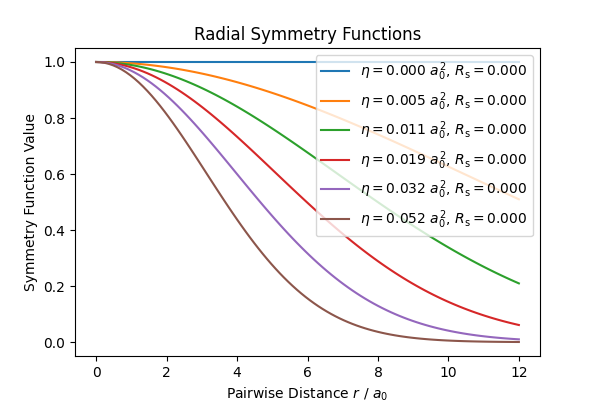

In [21]:
# set up plot
fig, ax = plt.subplots(figsize=(6, 4))

@widgets.interact(amount=(0, 12, 1), algorithm=['half', 'turn'])
def update(amount = 6, algorithm='half'):
    plt.clf()
    ax = plt.gca()
    radials = generate_symmetryfunctions(dataset, sftype=2, algorithm=algorithm,
                                         cutoff=12.0, amount=amount)
    radials.plot.radial(axes=ax)

### The Angular Symmetry Functions

For the angular SF it is quite similar as for the radial SF. But here, three atomic positions are included.

\begin{equation}
    G_{i}^{3} = 2^{\zeta - 1}\sum_{j}^{} \sum_{k}^{} \left[( 1 + \lambda \cdot cos \theta_{ijk})^{\zeta} \cdot e^{-\eta (R_{ij}^2 + R_{ik}^2 + R_{jk}^2)} \cdot f_{c}(R_{ij}) \cdot f_{c}(R_{ik}) \cdot f_{c}(R_{jk}) \right],
\end{equation}

the angle $\theta_{ijk} = \frac{\mathbf{R}_{ij} \cdot \mathbf{R}_{ik}}{R_{ij} \cdot R_{ik}}$ is centered at atom $i$ and the atomic distance vector is defined as $\mathbf{R}_{ij} = \mathbf{R}_{i} - \mathbf{R}_{j}$. Mostly used for the angular exponent $\zeta = 1, 2, 4 ,16$, gaussian exponent $\eta = 0$ and for $\lambda$ only $+1$ or $-1$ is possible. If many atoms of each element are present, angular SFs are usually not critical and a default set of SFs can be used.

Here a definition of an angular SF is given, which is similar to the definition of a radial SF. ``3`` defines the used type of SF, which needs the following parameters: ``Cu Cu`` to describe the neighboring atoms included in the angle, followed by $\eta$, $\lambda$, $\zeta$ and $R_\mathrm{c}$.

Below, you find different angular parts for angular SF with different $\zeta$ and $\lambda$ values. Fell free and play around.

FIXME: add description of the half and turn algorithms.

interactive(children=(IntSlider(value=4, description='amount', max=12), Dropdown(description='algorithm', inde…

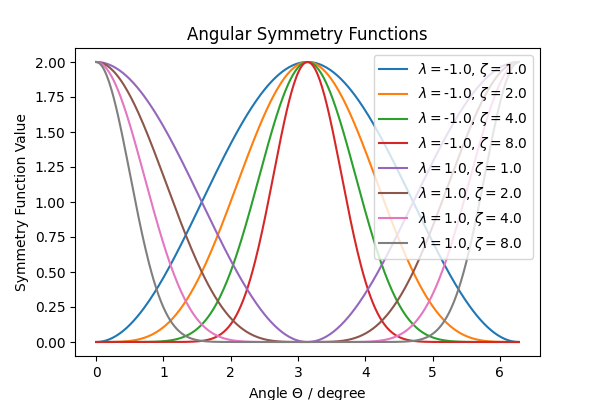

In [24]:
# set up plot
fig, ax = plt.subplots(figsize=(6, 4))

@widgets.interact(amount=(0, 12, 1), algorithm=['half', 'turn', 'literature'])
def update(amount = 4, algorithm='literature'):
    plt.clf()
    ax = plt.gca()
    angulars = generate_symmetryfunctions(dataset, sftype=3, amount=amount,
                                          algorithm=algorithm, cutoff=12.0)
    angulars.plot.angular(axes=ax)

#### Adding Symmetry Functions to `RunnerFit`

In [25]:
# Generate radial symmetry functions.     
mode1.parameters.symfunction_short.reset()

radials = generate_symmetryfunctions(dataset, sftype=2, algorithm='half',
                                     cutoff=12.0)

mode1.parameters.symfunction_short += radials

# Generate angular symmetry functions.                                                                                                                                                                                                                        
angulars = generate_symmetryfunctions(dataset, sftype=3, amount=4,
                                      algorithm='literature', cutoff=12.0)

mode1.parameters.symfunction_short += angulars

In [27]:
print(radials.storage)

<class 'pyiron_contrib.atomistics.runner.storageclasses.HDFSymmetryFunctionSet'>


In [20]:
print(mode1.input)

DataContainer({'parameters': DataContainer({'runner_mode': 1, 'elements': None, 'number_of_elements': 0, 'bond_threshold': 0.5, 'nn_type_short': 1, 'use_short_nn': 1, 'optmode_charge': 1, 'optmode_short_energy': 1, 'optmode_short_force': 1, 'points_in_memory': 1000, 'scale_symmetry_functions': 1, 'cutoff_type': 1, 'test_fraction': 0.1, 'use_short_forces': 1, 'epochs': 30, 'kalman_lambda_short': 0.98, 'kalman_nue_short': 0.9987, 'mix_all_points': 1, 'nguyen_widrow_weights_short': 1, 'repeated_energy_update': 1, 'short_energy_error_threshold': 0.1, 'short_energy_fraction': 1.0, 'short_force_error_threshold': 1.0, 'short_force_fraction': 0.1, 'use_old_weights_charge': 0, 'use_old_weights_short': 0, 'write_weights_epoch': 5, 'center_symmetry_functions': 1, 'precondition_weights': 1, 'global_activation_short': [['t', 't', 'l']], 'global_hidden_layers_short': 2, 'global_nodes_short': [[15, 15]], 'symfunction_short': [('Li', 2, 'Li', 0.0, 0.0, 12.0), ('Li', 2, 'Li', 0.004675055980246072, 0.0,

## Calculation of Symmetry Function Values - RuNNer Mode 1

In **RuNNer**'s mode 1 the following steps are performed:
- calculation of SF values,
- splitting of data set in train and test data set.

The amount of test structures is defined by the keyword ``test_fraction``. Here, ``test_fraction 0.10`` means 10% of the data set will be used for testing and is not part of the training data. ``use_short_forces`` keyword states to use also the atomic forces for the fitting process in ``mode 2``, but it is recommended to use it also in ``mode 1`` to create the necessary force files.

| Keyword | Default | Description |
|---------|---------|:-------------|
|runner_mode | 1| 
|symfunction_short | empty `SymmetryFunctionSet`| Specification of the symmetry functions for a specific element with a specific neighbor element combination for the short-range NN.
|elements | None| The element symbols of all elements in the system in arbitrary order. The number of specified elements must fit to the value of the keyword number_of_elements.
|number_of_elements | 0| Specify the number of chemical elements in the system.
|points_in_memory | 1000| This keyword controls memory consumption and IO and is therefore important to achieve an optimum performance of RuNNer. Has a different meaning depending on the current runner_mode.
|cutoff_type | 1| This keyword determines the cutoff function to be used for the symmetry functions.
|test_fraction | 0.1| Threshold for splitting between training and testing set in runner_mode 1.
|use_short_forces | True| Use forces for fitting the short range NN weights. In runner_mode 1, the files trainforces.data, testforces.data, trainforcese.data and testforcese.data are written. In runner_mode 2, these files are needed to use the short range forces for optimizing the short range weights. However, if the training data is different, the file scaling.data changes and either one of the keywords scale_symmetry_functions or center_symmetry_functions is used, the RMSE will be different.

In [30]:
# Run Mode 1.
mode1.parameters.runner_mode = 1                                                                                                                                                
mode1.run()

2022-05-25 15:27:31,737 - pyiron_log - WARNING - The job fit_data_lithium_mode1 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


### Output Mode 1

As said, the data set splitting and the calculation of the symmetry function values takes place here. Among general information of your data set and your SFs, you find explicitly how the data set is splitted. As shown in the example below, it is written what happens to each structure (called ``Point``) and if it goes to the training or test set and which number it has there. ``mode 1`` will prepare the necessary files for ``mode 2``:
* training data
 - function.data: SF values for each atom in each structure
 - trainstruct.data: structural information
 - trainforces.data: force information (if force fitting is used)
 

* test data
 - testing.data: SF values for each atom in each structure
 - teststruct.data: structural information
 - testforces.data: force information (if force fitting is used)

In [36]:
print(mode1.output)
split = mode1.output['splittraintest']
sfvalues = mode1.output['sfvalues'].to_runnerase()

DataContainer({'sfvalues': <pyiron_contrib.atomistics.runner.storageclasses.HDFSymmetryFunctionValues object at 0x7f26c1357c10>, 'splittraintest': HDFSplitTrainTest(n_train=165, n_test=11)})


FIXME: write some description of the containers and what they can do.

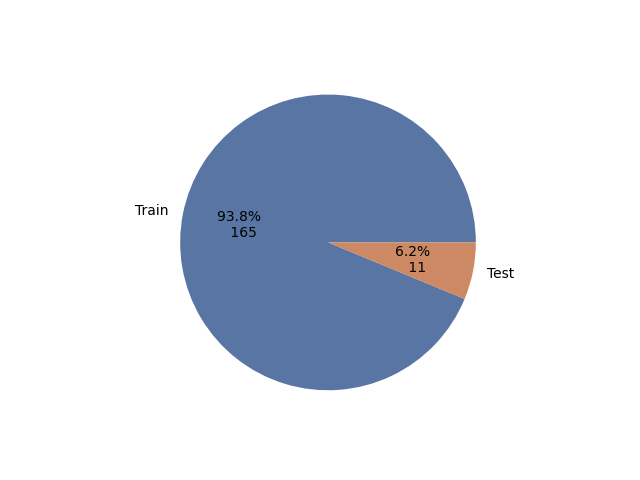

In [38]:
fig, ax = plt.subplots(1, 1)
split.plot.pie()
plt.show()

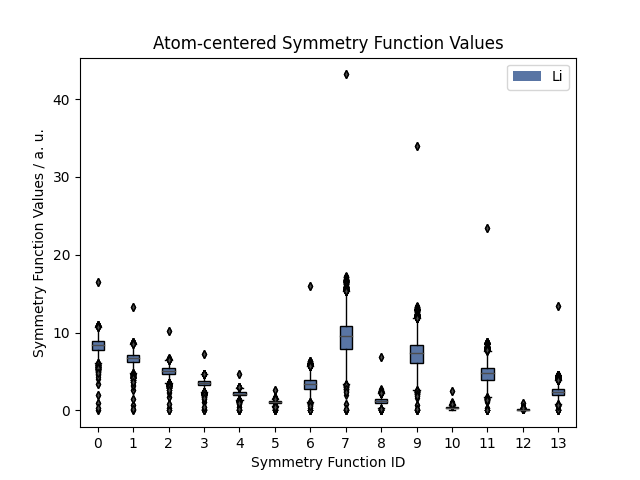

In [39]:
fig, ax = plt.subplots(1, 1)
sfvalues.plot.boxplot()
plt.show()

### Potential Training - RuNNer Mode 2

In ``mode 2``, the magic happens and your data will be fitted. The part below defines how the fitting in ``mode 2`` has to take place. ``epochs`` define how often **RuNNer** will loop over the training data to optimize the weights and biases of the NN, ``fitting_unit`` defines in which unit the output will be presented in ``mode 2``, all other files and units will stay in ``bohr`` and ``Hartree``. ``precondition_weights`` effects the initial weights and biases of the NN. In the second part, there are some parameters for the Kalman-Filter, ``repeated_energy_update`` repeats the energy update after a force component update, to increase the impact of the energies. This is slower in general, but might be necessary, since there a many more force components than energies. ``mix_all_points`` mixes the order of the training points for each epoch to improve the training. Often, the ranges of the symmetry functions are rather different in their order of magnitude and thus a rescaling of SFs can be advantageous numerically stated by ``scale_symmetry_functions`` keyword. Together with that, a centering of the SF average value to zero is performed for numerical reasons, since zero is the non-linear center of most activations  functions. ``short_force_fraction`` defines how much of the force components is randomly used for training the NN. The last part, defines to write certain files for each epoch, to analyze it in a later stage. There are many other keywords and options to present. However, you got an idea how **RuNNer** works and what to do to fit your first NNP. In the next part, first steps for analyzing the fit are presented.

| Keyword | Default | Description |
|---------|---------|:-------------|
|runner_mode | 1| Must be set to 2.
|nn_type_short | 1| Specify the NN type of the short-range part.
|use_short_nn | True| Use the a short range NN. Whether an atomic or pair-based energy expression is used is determined via the keyword nn_type_short.
|optmode_short_energy | 1| Specify the optimization algorithm for the short-range energy contributions.
|optmode_short_force | 1| Specify the optimization algorithm for the short-range forces.
|points_in_memory | 1000| This keyword controls memory consumption and IO and is therefore important to achieve an optimum performance of RuNNer. Has a different meaning depending on the current runner_mode.
|scale_symmetry_functions | True| Rescale symmetry functions to a certain interval (the default interval is 0 to 1). This has numerical advantages if the orders of magnitudes of different symmetry functions are very different. If the minimum and maximum value for a symmetry function is the same for all structures, rescaling is not possible and RuNNer will terminate with an error. The interval can be specified by the keywords 
|use_short_forces | True| Use forces for fitting the short range NN weights. In runner_mode 1, the files trainforces.data, testforces.data, trainforcese.data and testforcese.data are written. In runner_mode 2, these files are needed to use the short range forces for optimizing the short range weights. However, if the training data is different, the file scaling.data changes and either one of the keywords scale_symmetry_functions or center_symmetry_functions is used, the RMSE will be different.
|epochs | 30| The number of epochs for fitting. If 0 is specified, RuNNer will calculate the error and terminate without adjusting weights.
|kalman_lambda_short | 0.98| Kalman filter parameter $\lambda$ for the short range NN weight updates.
|kalman_nue_short | 0.9987| Kalman filter parameter $\lambda_0$ for the short range weight updates.
|mix_all_points | True| Randomly reorder the data points in the data set at the beginning of each new epoch.
|nguyen_widrow_weights_short | True| Initialize the short-range NN weights according to the scheme proposed by Nguyen and Widrow. The initial weights and bias values in the hidden layer are chosen such that the input space is evenly distributed over the nodes. This may speed up the training process.
|repeated_energy_update | True| If this keyword is set, the weights of the short-range NN are updated a second time after the force update with respect to the total energies in the data set. This usually results in a more accurate potential energy fitting at the cost of slightly detiorated forces.
|center_symmetry_functions | True| Shift the symmetry function values individually for each symmetry function such that the average is moved to zero. This may have numerical advantages, because zero is the center of the non-linear regions of most activation functions.
|precondition_weights | True| Shift the weights of the atomic NNs right after the initialization so that the standard deviation of the NN energies is the same as the standard deviation of the reference energies.
|global_activation_short | [['t' 't' 'l']]| Set the activation function for each hidden layer and the output layer in the short range NNs of all elements. 
|global_hidden_layers_short | 2| Set the default number of hidden layers in the short-range NNs of all elements. Internally 1 is added to maxnum_layers_short, which also includes the output layer.
|global_nodes_short | [[15 15]]| Set the default number of nodes in the hidden layers of the short-range NNs in case of nn_type_short 1. In the array, the entries 1 - maxnum_layersshort - 1 refer to the hidden layers. The first entry (0) refers to the nodes in the input layer and is determined automatically from the symmetry functions.

During the fitting process of the NN, the error function $\Gamma$ is minimized, which is defined as 
\begin{equation}
    \Gamma = \frac{1}{N_\mathrm{struct}} \sum_{i}^{N_\mathrm{struct}} (E_{NN}^{i} - E_{Ref}^{i})^2 = RMSE(E),
\end{equation}
if only energy fitting is used, which defines simultaneously the root-mean squared error of the energies $RMSE(E)$. This defines the differences of the reference data and the NNP predictions. During the epochs, the error decreases as you can see in the part of ``mode2`` output.

FIXME: add some comments which parameters to change and what the effects are.

In [40]:
# Run Mode 2.
# mode2 = mode1.restart('fit_data_lithium_mode2')
mode2 = pr.load('fit_data_lithium_mode2')
mode2.parameters.runner_mode = 2
mode2.parameters.epochs = 15
mode2.parameters.use_short_forces = True
mode2.run()

2022-05-25 15:33:21,679 - pyiron_log - WARNING - The job fit_data_lithium_mode2 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


FIXME: add description of pyiron output

In [145]:
mode2.output['fitresults'].table()

Epoch | RMSE(E) / eV/atom  | RMSE(F) / eV/Bohr  |
      |  Train   |  Test   |  Train   |  Test   |
-------------------------------------------------
    0 |  0.3346  |  0.1897 |  0.1010  |  0.0829 |
    1 |  0.0449  |  0.0302 |  0.0663  |  0.0488 |
    2 |  0.0323  |  0.0036 |  0.0521  |  0.0380 |
    3 |  0.0370  |  0.0077 |  0.0380  |  0.0278 |
    4 |  0.0208  |  0.0063 |  0.0328  |  0.0242 |
    5 |  0.0261  |  0.0030 |  0.0290  |  0.0216 |
    6 |  0.0087  |  0.0023 |  0.0271  |  0.0201 |
    7 |  0.0068  |  0.0022 |  0.0278  |  0.0202 |
    8 |  0.0056  |  0.0026 |  0.0267  |  0.0194 |
    9 |  0.0173  |  0.0030 |  0.0272  |  0.0196 |
   10 |  0.0093  |  0.0017 |  0.0257  |  0.0187 |
   11 |  0.0047  |  0.0019 |  0.0253  |  0.0186 | <-- Best Epoch
   12 |  0.0031  |  0.0021 |  0.0249  |  0.0184 |
   13 |  0.0029  |  0.0018 |  0.0246  |  0.0182 |
   14 |  0.0032  |  0.0026 |  0.0244  |  0.0181 |
   15 |  0.0027  |  0.0020 |  0.0243  |  0.0180 |


A first and simple plot to anlyze the progress of the fitting procedure, is to show the RMSEs over the epochs. Here, you can easily identify overfitting, if the training $RMSE$ is much lower than the test $RMSE$, for example.
Anyhow, the $RMSE$ is a rather strong reduction of the really complex potential energy surface (PES) and can only be understood as a rule of thumb for the quality of the NNP fit.

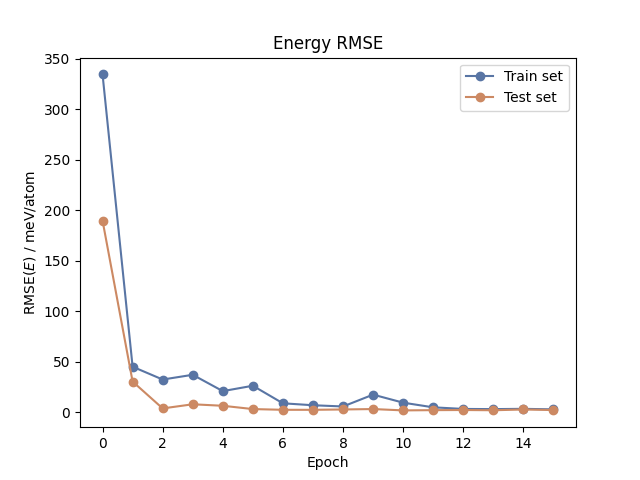

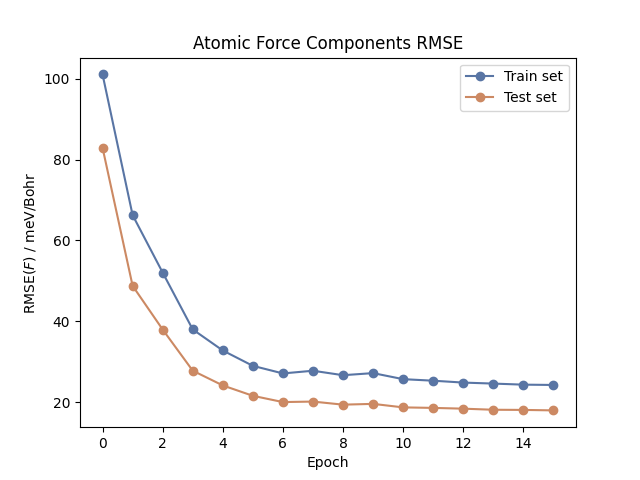

Object `mode2.output['fitresults'].plot` not found.


In [41]:
fig, ax = plt.subplots(1, 1)
mode2.output['fitresults'].plot.rmse_e()
plt.show()

fig, ax = plt.subplots(1, 1)
mode2.output['fitresults'].plot.rmse_f()
plt.show()

The ``mode 2`` output gives further information about the parameters of the fitting procedure, about the fitting data and it gives information about the defined SFs and the SFs ranges. These ranges define the known configuration space of your NNP and are used to identify the already mentioned ``extrapolations``. If the NNP is made to predict energies, forces or stress, it first calculates the SF vectors and compares these values to the trainings range shown below. If a SF value occurs, which is not in the range, **RuNNer** will give an ``extrapolation warning`` and tell the user, but you will still get your wanted energy, force or stress. Another usage of these ranges is to increase the data set and the known configuration space.

## Potential Evaluation - RuNNer Mode 3

**RuNNer** ``mode 3`` is the prediction mode and brings the NNP to application. 

| Keyword | Default | Description |
|---------|---------|:-------------|
|runner_mode | 1| Must be set to 3.
|calculate_forces | True| Calculate the atomic forces in runner_mode 3 and write them to the files runner.out and nnforces.out.

In [43]:
# Run Mode 3.
pr.remove_job('fit_data_lithium_mode3')
mode3 = mode2.restart('fit_data_lithium_mode3')
mode3.parameters.runner_mode = 3
mode3.parameters.calculate_forces = True
mode3.run()#delete_existing_job=True)

DataContainer({'parameters': DataContainer({'runner_mode': 3, 'elements': None, 'number_of_elements': 0, 'bond_threshold': 0.5, 'nn_type_short': 1, 'use_short_nn': 1, 'optmode_charge': 1, 'optmode_short_energy': 1, 'optmode_short_force': 1, 'points_in_memory': 1000, 'scale_symmetry_functions': 1, 'cutoff_type': 1, 'test_fraction': 0.1, 'use_short_forces': 1, 'epochs': 15, 'kalman_lambda_short': 0.98, 'kalman_nue_short': 0.9987, 'mix_all_points': 1, 'nguyen_widrow_weights_short': 1, 'repeated_energy_update': 1, 'short_energy_error_threshold': 0.1, 'short_energy_fraction': 1.0, 'short_force_error_threshold': 1.0, 'short_force_fraction': 0.1, 'use_old_weights_charge': 0, 'use_old_weights_short': 0, 'write_weights_epoch': 5, 'center_symmetry_functions': 1, 'precondition_weights': 1, 'global_activation_short': [['t', 't', 'l']], 'global_hidden_layers_short': 2, 'global_nodes_short': [[15, 15]], 'calculate_forces': True, 'symfunction_short': [('Li', 2, 'Li', 0.0, 0.0, 12.0), ('Li', 2, 'Li', 

/home/kalm/dcmnts/uni/promotion/src/runnerase/runnerase/io/ase.py:313: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  forces = np.array([i.get_forces() for i in pred_structures])


For a more detailed analyze, you could have a look at the predicted energies and forces per structure. This is quite useful to identify inaccurately described structures. The training data set may has a specific order of different structures (bulk, slab, cluster, ...) and you can identify, if some parts of the data set are described inaccurately in general. The second plot shows the atomic energy prediction of the NNP over the reference values. For a perfect fit, all points will be on the blue line, but as we can see this is not the case. In this plot, we can identify, if some energies ranges are not well described in our data set. This is related to our first data set analysis above.

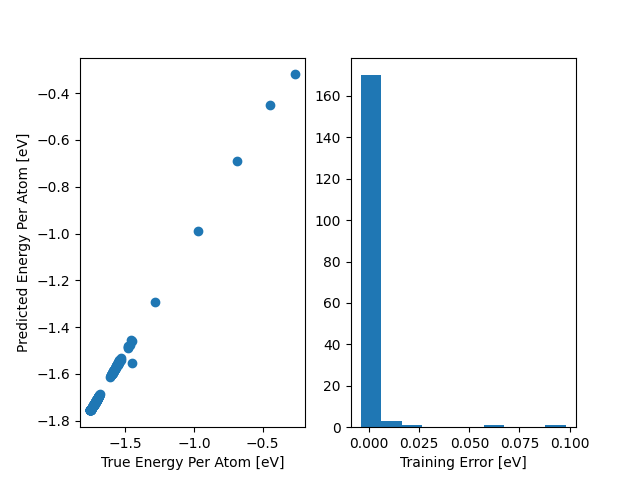

In [44]:
fig, ax = plt.subplots(1, 1)
mode3.plot.energy_scatter_hist()
plt.show()

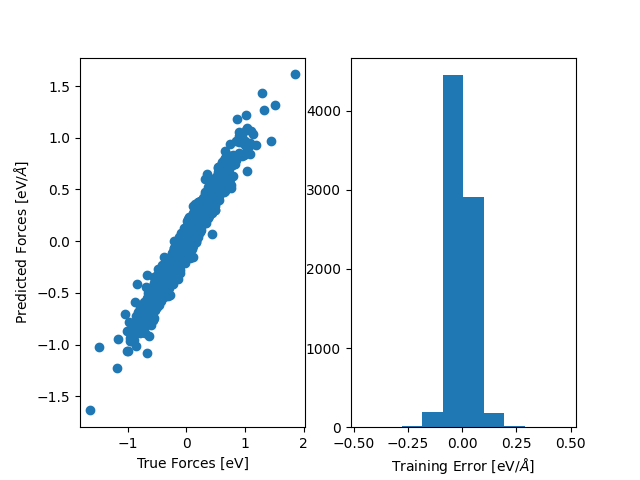

In [45]:
fig, ax = plt.subplots(1, 1)
mode3.plot.force_scatter_hist(axis=0)
plt.show()

## Using the potential

Via N2P2, NNP can also be used in LAMMPS. A first application of the NNP in the Li case is to predict the correct minimum energy.

In [46]:
pot = mode3.get_lammps_potential(elements=['Li'])
display(pot)

,Name,Filename,Model,Species,Config
0,RuNNer-Li,"[/home/kalm/dcmnts/uni/promotion/work/workshop_bochum/handson_notebook/workshop-pyiron-demonstration/notebooks/AlLi-Fit/AlLi-Fit/fit_data_lithium_mode3_hdf5/fit_data_lithium_mode3/input.nn, /home/...",RuNNer,[Li],"[pair_style nnp dir ""./"" showew yes showewsum 0 resetew no maxew 100 cflength 1.8897261328 cfenergy 0.0367493254 emap ""0:Li""\n, pair_coeff * * 12.0\n]"


* Do short simulation.
* Visualize trajectory

The data set, you will fit is a strongly reduced subset of the data shown above. For comparison, the same plot is shown here.

**Be aware of fitting a larger data set, since it will run some time, roughly six hours!**